In [5]:
import pandas as pd
import matplotlib.pyplot as plt

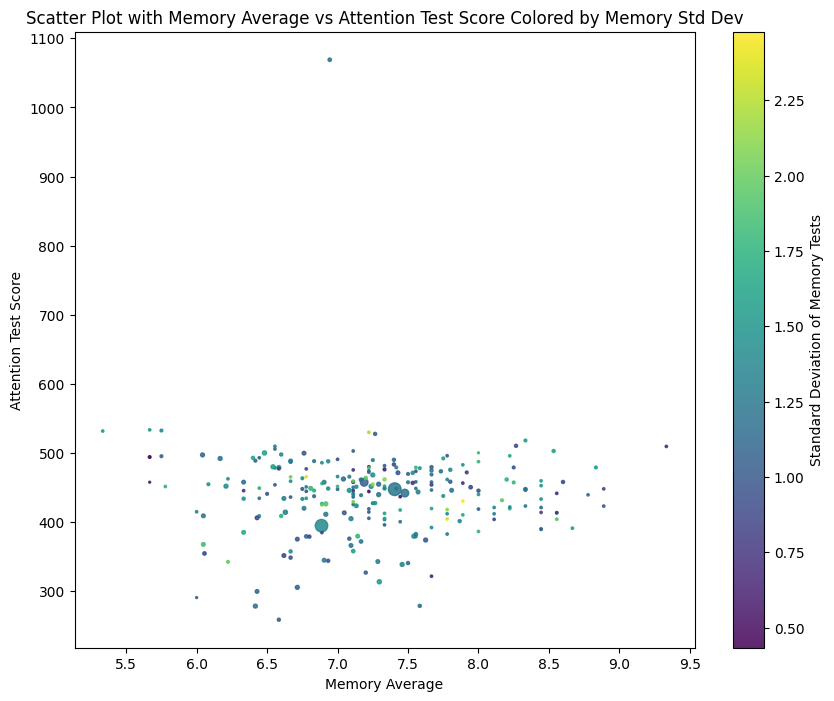

In [6]:
# Load the data from the CSV file
file_path = 'csv_files\output_updated.csv'
data = pd.read_csv(file_path)

# Remove non-numeric 'RoomID' entries
data['RoomID'] = pd.to_numeric(data['RoomID'], errors='coerce')
data.dropna(subset=['RoomID'], inplace=True)

# Create a new DataFrame for processing to avoid SettingWithCopyWarning
processed_data = data.copy()

# Calculate the standard deviation for the memory test scores for each participant
memory_tests = ['MemoryTest1', 'MemoryTest2', 'MemoryTest3']
processed_data['MemoryStdDev'] = processed_data[memory_tests].std(axis=1)

# Group by 'RoomID' and calculate the mean of all columns including the newly calculated 'MemoryStdDev'
# Ensure all columns are numeric to avoid TypeError
numeric_columns = ['MemoryTest1', 'MemoryTest2', 'MemoryTest3', 'MemoryAverage', 'AttentionTest', 'MemoryStdDev']
memory_and_attention = processed_data.groupby('RoomID')[numeric_columns].mean().reset_index()

# Count the number of occurrences of each 'RoomID'
room_counts = processed_data['RoomID'].value_counts().reindex(memory_and_attention['RoomID']).values

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    memory_and_attention['MemoryAverage'], 
    memory_and_attention['AttentionTest'], 
    s=room_counts,  # Use the room counts as sizes for the dots
    c=memory_and_attention['MemoryStdDev'], 
    cmap='viridis',
    alpha=0.85  # Semi-transparency for the dots
)

# Create a colorbar for the colormap
plt.colorbar(scatter, label='Standard Deviation of Memory Tests')

# Set the labels for the axes
plt.xlabel('Memory Average')
plt.ylabel('Attention Test Score')

# Set the title for the plot
plt.title('Scatter Plot with Memory Average vs Attention Test Score Colored by Memory Std Dev')

# Show the plot
plt.show()

In [7]:
# Load the data from the CSV file
file_path_form = 'csv_files\Forma.csv'
dimensions_data = pd.read_csv(file_path_form)

# Clean the 'Height' and 'Width' columns
dimensions_data['Height'] = dimensions_data['Height'].str.replace(',', '.').str.replace(' m', '').astype(float)
dimensions_data['Width'] = dimensions_data['Width'].str.replace(',', '.').str.replace(' m', '').astype(float)

# Merge the grouped memory and attention data with the dimensions data on 'RoomID'
dimensions_memory_attention = pd.merge(memory_and_attention, dimensions_data, on='RoomID', how='inner')

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

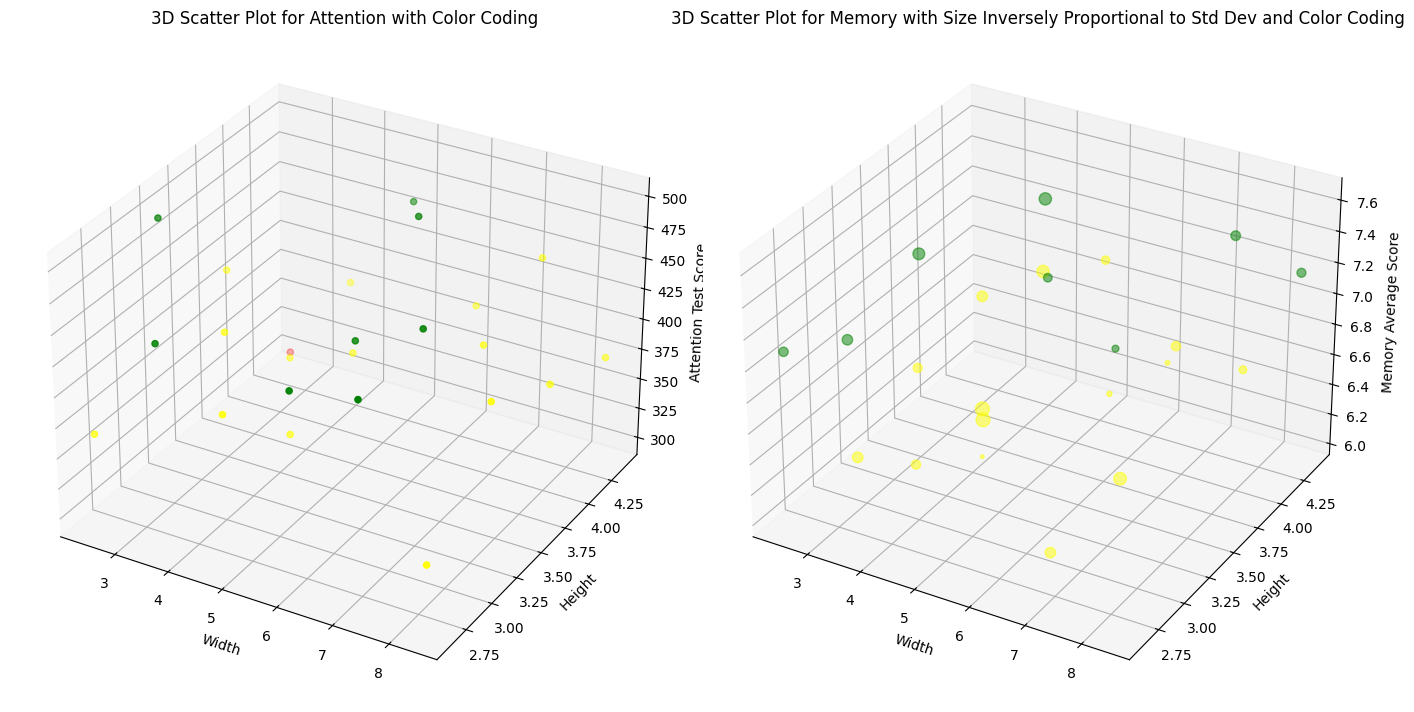

In [9]:
# Prepare the data
# Inverse of the standard deviation for the memory plot sizes (adding a small constant to avoid division by zero)
inverse_std = 1 / (dimensions_memory_attention['MemoryStdDev'] + 1e-6)

# Normalize the sizes to make them suitable for plotting (you can adjust the multiplier as needed)
sizes = (inverse_std - inverse_std.min()) / (inverse_std.max() - inverse_std.min()) * 100

# Define color bins for memory scores
memory_bins = [0, 3.5, 7, 10.5, 14]
memory_colors = ['red', 'yellow', 'green', 'blue']

# Define color bins for attention scores based on given thresholds
attention_bins = [0, 311.75, 440.5, 570, np.inf]
attention_colors = ['red', 'yellow', 'green', 'blue']

# Map memory scores to colors
memory_color_labels = pd.cut(dimensions_memory_attention['MemoryAverage'], bins=memory_bins, labels=memory_colors, include_lowest=True)

# Map attention scores to colors
attention_color_labels = pd.cut(dimensions_memory_attention['AttentionTest'], bins=attention_bins, labels=attention_colors, include_lowest=True)

# Update the plotting section to include the color separation
# Create a figure for the 3D plots
fig = plt.figure(figsize=(14, 7))

# Create a 3D subplot for attention
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(
    dimensions_memory_attention['Width'],
    dimensions_memory_attention['Height'],
    dimensions_memory_attention['AttentionTest'],
    c=attention_color_labels,
    marker='o'
)
ax1.set_xlabel('Width')
ax1.set_ylabel('Height')
ax1.set_zlabel('Attention Test Score')
ax1.set_title('3D Scatter Plot for Attention with Color Coding')

# Create a 3D subplot for memory
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(
    dimensions_memory_attention['Width'],
    dimensions_memory_attention['Height'],
    dimensions_memory_attention['MemoryAverage'],
    s=sizes,
    c=memory_color_labels,
    alpha=0.5
)
ax2.set_xlabel('Width')
ax2.set_ylabel('Height')
ax2.set_zlabel('Memory Average Score')
ax2.set_title('3D Scatter Plot for Memory with Size Inversely Proportional to Std Dev and Color Coding')

# Show the plots
plt.tight_layout()
plt.show()



import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Activate plotly in notebook mode
init_notebook_mode(connected=True)

# Create trace for attention plot
trace_attention = go.Scatter3d(
    x=dimensions_memory_attention['Width'],
    y=dimensions_memory_attention['Height'],
    z=dimensions_memory_attention['AttentionTest'],
    mode='markers',
    marker=dict(
        size=5,
        color=attention_color_labels,  # Use the color labels generated previously
        opacity=0.8
    )
)

# Create trace for memory plot
trace_memory = go.Scatter3d(
    x=dimensions_memory_attention['Width'],
    y=dimensions_memory_attention['Height'],
    z=dimensions_memory_attention['MemoryAverage'],
    mode='markers',
    marker=dict(
        size=sizes,  # Use the sizes calculated previously
        color=memory_color_labels,  # Use the color labels generated previously
        opacity=0.8
    )
)

# Define the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Width'),
        yaxis=dict(title='Height'),
        zaxis=dict(title='Attention Test Score')
    )
)

# Create figure for attention plot
fig_attention = go.Figure(data=[trace_attention], layout=layout)
iplot(fig_attention)

# Update layout for the memory plot
layout.scene.zaxis.title = 'Memory Average Score'
# Create figure for memory plot
fig_memory = go.Figure(data=[trace_memory], layout=layout)
iplot(fig_memory)

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

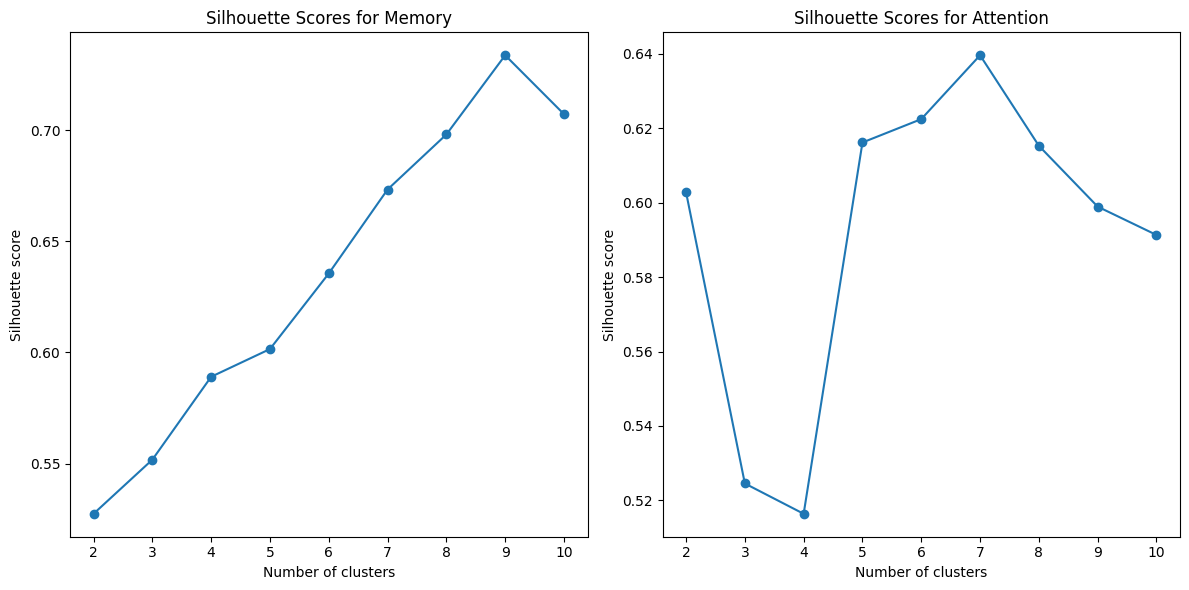

The optimal number of clusters for 'MemoryAverage' is: 9
The optimal number of clusters for 'AttentionTest' is: 7


In [11]:
# Function to calculate silhouette scores for different numbers of clusters
def silhouette_scores(dimensions_memory_attention, feature):
    scores = []
    range_values = range(2, 11)
    for n_clusters in range_values:  # Testing from 2 to 10 clusters
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        labels = kmeans.fit_predict(dimensions_memory_attention[[feature]].values)
        silhouette_avg = silhouette_score(dimensions_memory_attention[[feature]].values, labels)
        scores.append(silhouette_avg)
    return scores, range_values

# Calculate silhouette scores for 'MemoryAverage'
memory_scores, memory_range = silhouette_scores(dimensions_memory_attention, 'MemoryAverage')

# Calculate silhouette scores for 'AttentionTest'
attention_scores, attention_range = silhouette_scores(dimensions_memory_attention, 'AttentionTest')

# Plotting the silhouette scores
plt.figure(figsize=(12, 6))

# Plot for 'MemoryAverage'
plt.subplot(1, 2, 1)
plt.plot(memory_range, memory_scores, marker='o')
plt.title('Silhouette Scores for Memory')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

# Plot for 'AttentionTest'
plt.subplot(1, 2, 2)
plt.plot(attention_range, attention_scores, marker='o')
plt.title('Silhouette Scores for Attention')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

plt.tight_layout()
plt.show()

# Find the number of clusters with the highest silhouette score for 'MemoryAverage'
optimal_clusters_memory = memory_range[memory_scores.index(max(memory_scores))]
print(f"The optimal number of clusters for 'MemoryAverage' is: {optimal_clusters_memory}")

# Find the number of clusters with the highest silhouette score for 'AttentionTest'
optimal_clusters_attention = attention_range[attention_scores.index(max(attention_scores))]
print(f"The optimal number of clusters for 'AttentionTest' is: {optimal_clusters_attention}")

In [12]:
# Apply K-Means to get the cluster labels for MemoryAverage in dimensions_memory_attention DataFrame
kmeans_memory = KMeans(n_clusters=9, random_state=42)
memory_labels = kmeans_memory.fit_predict(dimensions_memory_attention[['MemoryAverage']].values)
dimensions_memory_attention['MemoryLabel'] = memory_labels

c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [33]:
# Apply K-Means to get the cluster labels for AttentionTest in dimensions_memory_attention DataFrame
kmeans_attention = KMeans(n_clusters=7, random_state=42)
attention_labels = kmeans_attention.fit_predict(dimensions_memory_attention[['AttentionTest']].values)
dimensions_memory_attention['AttentionLabel'] = attention_labels

# Now, 'MemoryLabel' and 'AttentionLabel' are the target classes for classification models
# Save this data for future use if needed
#dimensions_memory_attention.to_csv('labeled_data.csv', index=False)

c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
dimensions_memory_attention

,RoomID,MemoryTest1,MemoryTest2,MemoryTest3,MemoryAverage,AttentionTest,MemoryStdDev,Height,Width,MemoryLabel,AttentionLabel
0,28.0,6.810127,7.000000,6.848101,6.886076,394.854074,1.400127,3.802,8.4,5,4
1,62.0,6.428571,6.428571,6.142857,6.333333,457.900952,1.138345,2.602,7.2,4,0
2,64.0,7.000000,6.800000,7.000000,6.933333,344.135998,0.967385,2.602,8.4,5,1
3,76.0,6.875000,7.125000,6.750000,6.916667,426.443768,1.911338,3.202,8.4,5,2
4,86.0,7.125000,7.500000,7.125000,7.250000,468.271249,1.477205,3.202,7.2,6,0
5,96.0,6.625000,7.500000,6.625000,6.916667,411.375003,1.251275,3.802,7.2,5,2
6,204.0,8.333333,6.000000,7.166667,7.166667,372.055556,1.278975,4.402,8.4,1,5
7,205.0,8.000000,6.625000,7.250000,7.291667,439.815417,1.215460,4.402,7.2,6,0
8,206.0,6.142857,6.000000,6.857143,6.333333,385.250000,1.688234,4.402,6.0,4,4
9,207.0,6.777778,6.666667,6.000000,6.481481,500.148148,1.640055,3.802,6.0,7,3


In [14]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Accuracy for MemoryLabel with XGBoost: 0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         3

    accuracy                           0.20         5
   macro avg       0.20      0.20      0.20         5
weighted avg       0.20      0.20      0.20         5



c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

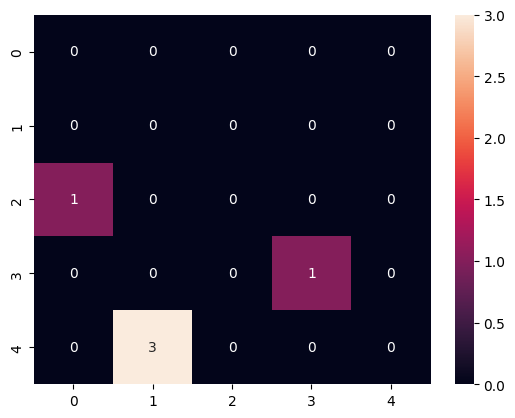

Accuracy for MemoryLabel with Gradient Boosting: 0.4
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           8       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.38      0.50      0.42         5
weighted avg       0.30      0.40      0.33         5



c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

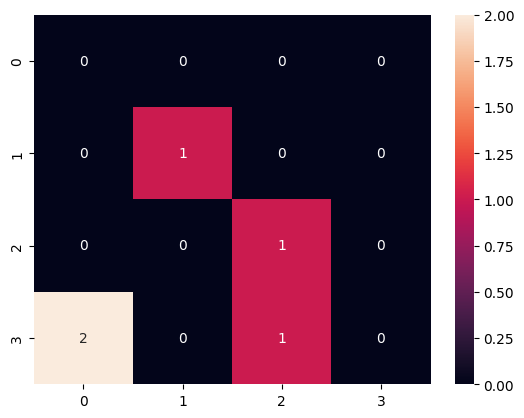

In [34]:
# Select features and the target for 'Label'
features_memory = ['MemoryAverage', 'Height', 'Width']
X_memory = dimensions_memory_attention[features_memory]
y_memory = dimensions_memory_attention['MemoryLabel']

# Split the data into training and testing sets
X_train_memory, X_test_memory, y_memory_train, y_memory_test = train_test_split(X_memory, y_memory, test_size=0.2, random_state=42)

# XGBoost Classifier for 'MemoryLabel'
xgb_model_memory = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model_memory.fit(X_train_memory, y_memory_train)

# Predictions
y_memory_pred = xgb_model_memory.predict(X_test_memory)

# Evaluation
memory_accuracy = accuracy_score(y_memory_test, y_memory_pred)
print(f"Accuracy for MemoryLabel with XGBoost: {memory_accuracy}")
print(classification_report(y_memory_test, y_memory_pred))

# Confusion Matrix
memory_cm = confusion_matrix(y_memory_test, y_memory_pred)
sns.heatmap(memory_cm, annot=True, fmt='d')
plt.show()

# Gradient Boosting Classifier for 'MemoryLabel'
gb_model_memory = GradientBoostingClassifier()
gb_model_memory.fit(X_train_memory, y_memory_train)

# Predictions
y_memory_gb_pred = gb_model_memory.predict(X_test_memory)

# Evaluation
memory_gb_accuracy = accuracy_score(y_memory_test, y_memory_gb_pred)
print(f"Accuracy for MemoryLabel with Gradient Boosting: {memory_gb_accuracy}")
print(classification_report(y_memory_test, y_memory_gb_pred))

# Confusion Matrix
memory_gb_cm = confusion_matrix(y_memory_test, y_memory_gb_pred)
sns.heatmap(memory_gb_cm, annot=True, fmt='d')
plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

Accuracy for AttentionLabel with XGBoost: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         1

    accuracy                           0.71         7
   macro avg       0.53      0.67      0.58         7
weighted avg       0.55      0.71      0.61         7



c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

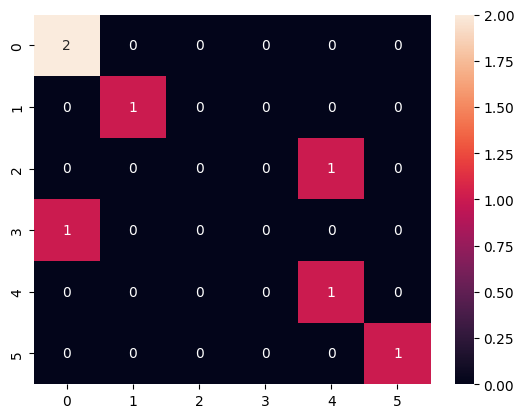

[0 1 2 3 4 5]
Accuracy for AttentionLabel with Gradient Boosting: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1

    accuracy                           0.71         7
   macro avg       0.53      0.67      0.58         7
weighted avg       0.55      0.71      0.61         7



c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

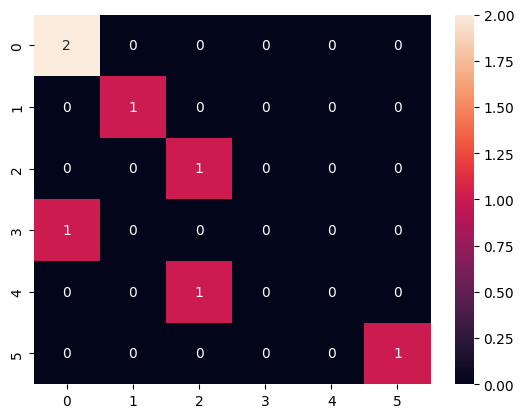

In [36]:
# Select features and the target for 'AttentionLabel'
features_attention = ['AttentionTest', 'Height', 'Width']
X_attention = dimensions_memory_attention[features_attention]
y_attention = dimensions_memory_attention['AttentionLabel']

# Determine the count for each class in 'AttentionLabel'
class_counts = dimensions_memory_attention['AttentionLabel'].value_counts()

# Identify classes with more than 1 instance (or another threshold you choose)
valid_classes = class_counts[class_counts > 1].index

# Filter your dataset to only include valid classes
filtered_indices = dimensions_memory_attention['AttentionLabel'].isin(valid_classes)
X_filtered = dimensions_memory_attention[filtered_indices].drop(columns=['AttentionLabel'])
y_filtered = dimensions_memory_attention[filtered_indices]['AttentionLabel']

# Now you can split your filtered dataset
X_train_attention, X_test_attention, y_attention_train, y_attention_test = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)


#print(np.unique(y_attention))
#print(np.unique(y_attention_train))
#print(np.unique(y_attention_test))


# XGBoost Classifier for 'AttentionLabel'
xgb_model_attention = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model_attention.fit(X_train_attention, y_attention_train)

# Predictions
y_attention_pred = xgb_model_attention.predict(X_test_attention)

# Evaluation
attention_accuracy = accuracy_score(y_attention_test, y_attention_pred)
print(f"Accuracy for AttentionLabel with XGBoost: {attention_accuracy}")
print(classification_report(y_attention_test, y_attention_pred))

# Confusion Matrix
attention_cm = confusion_matrix(y_attention_test, y_attention_pred)
sns.heatmap(attention_cm, annot=True, fmt='d')
plt.show()

# Gradient Boosting Classifier for 'AttentionLabel'
gb_model_attention = GradientBoostingClassifier()
gb_model_attention.fit(X_train_attention, y_attention_train)

print(xgb_model_attention.classes_)

# Predictions
y_attention_gb_pred = gb_model_attention.predict(X_test_attention)

# Evaluation
attention_gb_accuracy = accuracy_score(y_attention_test, y_attention_gb_pred)
print(f"Accuracy for AttentionLabel with Gradient Boosting: {attention_gb_accuracy}")
print(classification_report(y_attention_test, y_attention_gb_pred))

# Confusion Matrix
attention_gb_cm = confusion_matrix(y_attention_test, y_attention_gb_pred)
sns.heatmap(attention_gb_cm, annot=True, fmt='d')
plt.show()